In [1]:
import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import models
import utils as ut
from models import AEBase, Predictor, PretrainedPredictor

import scanpypip.preprocessing as pp
import scanpy as sc

In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
class Arguments:
    def __init__(self):   
        self.epochs = 500
        self.bottleneck = 512
        self.missing_value = np.nan
        self.data_path = "data/GSE108394/GSM2897334/"
        self.test_size = 0.2
        self.valid_size = 0.2
        self.model_store_path = "saved/models/"
        self.logging_file = "saved/logs/"
        self.batch_size = 200
        self.ft_h_dims = "512,256"
        self.var_genes_disp = 0
        self.pretrain_path = "saved/models/"
        self.min_n_genes = 0
        self.max_n_genes = 20000
        self.min_g = 200
        self.min_c = 3

        
args = Arguments()

In [3]:
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
na = args.missing_value
data_path = args.data_path
test_size = args.test_size
valid_size = args.valid_size
g_disperson = args.var_genes_disp
min_n_genes = args.min_n_genes
max_n_genes = args.max_n_genes
model_path = args.model_store_path
pretrain_path = args.pretrain_path
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.ft_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims))


In [4]:
now=time.strftime("%Y-%m-%d-%H-%M-%S")
log_path = log_path+now+".txt"
export_name = data_path.replace("/","")
pretrain_path = "saved/models/ae_"+export_name+now+".pkl"

In [5]:
adata = sc.read_10x_mtx(
 'data/GSE108394/GSM2897334/',  # the directory with the `.mtx` file 
 var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
 cache=True)                              # write a cache file for faster subsequent reading


In [6]:
adata = pp.receipe_my(adata,l_n_genes=min_n_genes,r_n_genes=max_n_genes,filter_mincells=args.min_c,
                      filter_mingenes=args.min_g,normalize=True,log=True)

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
D:\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


(7414, 18158)


D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
D:\Anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored

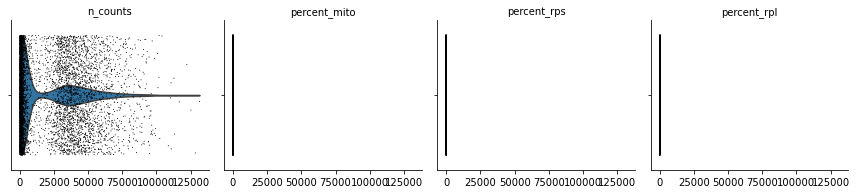

In [7]:
sc.pl.violin(adata, ['n_counts',"percent_mito",'percent_rps', 'percent_rpl'],
             jitter=0.4, multi_panel=True,save=export_name)

In [8]:
sc.pp.highly_variable_genes(adata,min_disp=g_disperson,max_disp=np.inf)

sc.pl.highly_variable_genes(adata,save=export_name)

In [10]:
adata.raw = adata

adata = adata[:, adata.var.highly_variable]

data=adata.X

In [13]:
mmscaler = preprocessing.MinMaxScaler()

In [14]:
data = mmscaler.fit_transform(data.todense())

In [15]:
X_train, X_valid = train_test_split(data, test_size=valid_size, random_state=42)

In [16]:
print(X_train.shape, X_valid.shape)

(5931, 6294) (1483, 6294)


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

# Construct datasets and data loaders
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_allTensor = torch.FloatTensor(data).to(device)

train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)


X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

dataloaders_pretrain = {'train':X_trainDataLoader,'val':X_validDataLoader}


cuda:0


In [18]:
encoder = AEBase(input_dim=data.shape[1],latent_dim=dim_au_out,h_dims=encoder_hdims)
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    encoder.cuda()

print(encoder)
encoder.to(device)
optimizer_e = optim.Adam(encoder.parameters(), lr=1e-2)
loss_function_e = nn.MSELoss()
exp_lr_scheduler_e = lr_scheduler.ReduceLROnPlateau(optimizer_e)
encoder,loss_report_en = ut.train_extractor_model(net=encoder,data_loaders=dataloaders_pretrain,
                            optimizer=optimizer_e,loss_function=loss_function_e,
                            n_epochs=epochs,scheduler=exp_lr_scheduler_e,save_path=pretrain_path)

print("Pretrained finished")

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6294, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=256, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=512, out_features=6294, bias=True)
    (1): Sigmoid()
  )
)
Epo

train Loss: 0.00002956. Learning rate = 0.01
val Loss: 0.00003096. Learning rate = 0.01
Epoch 66/499
----------
train Loss: 0.00002954. Learning rate = 0.01
val Loss: 0.00003090. Learning rate = 0.01
Epoch 67/499
----------
train Loss: 0.00002949. Learning rate = 0.01
val Loss: 0.00003104. Learning rate = 0.01
Epoch 68/499
----------
train Loss: 0.00002953. Learning rate = 0.01
val Loss: 0.00003064. Learning rate = 0.01
Epoch 69/499
----------
train Loss: 0.00002951. Learning rate = 0.01
val Loss: 0.00003084. Learning rate = 0.01
Epoch 70/499
----------
train Loss: 0.00002954. Learning rate = 0.01
val Loss: 0.00003075. Learning rate = 0.01
Epoch 71/499
----------
train Loss: 0.00002949. Learning rate = 0.01
val Loss: 0.00003105. Learning rate = 0.01
Epoch 72/499
----------
train Loss: 0.00002949. Learning rate = 0.01
val Loss: 0.00003093. Learning rate = 0.01
Epoch 73/499
----------
train Loss: 0.00002949. Learning rate = 0.01
val Loss: 0.00003098. Learning rate = 0.01
Epoch 74/499
---

train Loss: 0.00002897. Learning rate = 0.01
val Loss: 0.00003064. Learning rate = 0.01
Epoch 139/499
----------
train Loss: 0.00002900. Learning rate = 0.01
val Loss: 0.00003069. Learning rate = 0.01
Epoch 140/499
----------
train Loss: 0.00002896. Learning rate = 0.01
val Loss: 0.00003078. Learning rate = 0.01
Epoch 141/499
----------
train Loss: 0.00002895. Learning rate = 0.01
val Loss: 0.00003073. Learning rate = 0.01
Epoch 142/499
----------
train Loss: 0.00002897. Learning rate = 0.01
val Loss: 0.00003050. Learning rate = 0.01
Epoch 143/499
----------
train Loss: 0.00002892. Learning rate = 0.01
val Loss: 0.00003054. Learning rate = 0.01
Epoch 144/499
----------
train Loss: 0.00002895. Learning rate = 0.01
val Loss: 0.00003056. Learning rate = 0.01
Epoch 145/499
----------
train Loss: 0.00002894. Learning rate = 0.01
val Loss: 0.00003028. Learning rate = 0.01
Epoch 146/499
----------
train Loss: 0.00002896. Learning rate = 0.01
val Loss: 0.00003074. Learning rate = 0.01
Epoch 14

train Loss: 0.00002869. Learning rate = 0.0001
val Loss: 0.00003036. Learning rate = 0.0001
Epoch 212/499
----------
train Loss: 0.00002867. Learning rate = 0.0001
val Loss: 0.00003007. Learning rate = 0.0001
Epoch 213/499
----------
train Loss: 0.00002866. Learning rate = 0.0001
val Loss: 0.00003005. Learning rate = 0.0001
Epoch 214/499
----------
train Loss: 0.00002864. Learning rate = 0.0001
val Loss: 0.00003030. Learning rate = 0.0001
Epoch 215/499
----------
train Loss: 0.00002866. Learning rate = 0.0001
val Loss: 0.00003033. Learning rate = 0.0001
Epoch 216/499
----------
train Loss: 0.00002866. Learning rate = 0.0001
val Loss: 0.00003028. Learning rate = 0.0001
Epoch 217/499
----------
train Loss: 0.00002865. Learning rate = 0.0001
val Loss: 0.00003034. Learning rate = 0.0001
Epoch 218/499
----------
train Loss: 0.00002865. Learning rate = 0.0001
val Loss: 0.00003040. Learning rate = 0.0001
Epoch 219/499
----------
train Loss: 0.00002863. Learning rate = 0.0001
val Loss: 0.00003

train Loss: 0.00002862. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003043. Learning rate = 1.0000000000000004e-08
Epoch 273/499
----------
train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00002978. Learning rate = 1.0000000000000004e-08
Epoch 274/499
----------
train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003045. Learning rate = 1.0000000000000004e-08
Epoch 275/499
----------
train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003004. Learning rate = 1.0000000000000004e-08
Epoch 276/499
----------
train Loss: 0.00002867. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003025. Learning rate = 1.0000000000000004e-08
Epoch 277/499
----------
train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00002998. Learning rate = 1.0000000000000004e-08
Epoch 278/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003014. Learning rate = 1.000

train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003043. Learning rate = 1.0000000000000004e-08
Epoch 328/499
----------
train Loss: 0.00002867. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003008. Learning rate = 1.0000000000000004e-08
Epoch 329/499
----------
train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003033. Learning rate = 1.0000000000000004e-08
Epoch 330/499
----------
train Loss: 0.00002862. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003023. Learning rate = 1.0000000000000004e-08
Epoch 331/499
----------
train Loss: 0.00002862. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003014. Learning rate = 1.0000000000000004e-08
Epoch 332/499
----------
train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003017. Learning rate = 1.0000000000000004e-08
Epoch 333/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003020. Learning rate = 1.000

train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003051. Learning rate = 1.0000000000000004e-08
Epoch 383/499
----------
train Loss: 0.00002864. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003025. Learning rate = 1.0000000000000004e-08
Epoch 384/499
----------
train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003023. Learning rate = 1.0000000000000004e-08
Epoch 385/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003000. Learning rate = 1.0000000000000004e-08
Epoch 386/499
----------
train Loss: 0.00002869. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003025. Learning rate = 1.0000000000000004e-08
Epoch 387/499
----------
train Loss: 0.00002868. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003022. Learning rate = 1.0000000000000004e-08
Epoch 388/499
----------
train Loss: 0.00002862. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003036. Learning rate = 1.000

train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003065. Learning rate = 1.0000000000000004e-08
Epoch 438/499
----------
train Loss: 0.00002864. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003026. Learning rate = 1.0000000000000004e-08
Epoch 439/499
----------
train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003031. Learning rate = 1.0000000000000004e-08
Epoch 440/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003028. Learning rate = 1.0000000000000004e-08
Epoch 441/499
----------
train Loss: 0.00002866. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003027. Learning rate = 1.0000000000000004e-08
Epoch 442/499
----------
train Loss: 0.00002867. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003029. Learning rate = 1.0000000000000004e-08
Epoch 443/499
----------
train Loss: 0.00002862. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003032. Learning rate = 1.000

train Loss: 0.00002868. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003031. Learning rate = 1.0000000000000004e-08
Epoch 493/499
----------
train Loss: 0.00002865. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003073. Learning rate = 1.0000000000000004e-08
Epoch 494/499
----------
train Loss: 0.00002867. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003036. Learning rate = 1.0000000000000004e-08
Epoch 495/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003013. Learning rate = 1.0000000000000004e-08
Epoch 496/499
----------
train Loss: 0.00002864. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003032. Learning rate = 1.0000000000000004e-08
Epoch 497/499
----------
train Loss: 0.00002863. Learning rate = 1.0000000000000004e-08
val Loss: 0.00002989. Learning rate = 1.0000000000000004e-08
Epoch 498/499
----------
train Loss: 0.00002864. Learning rate = 1.0000000000000004e-08
val Loss: 0.00003037. Learning rate = 1.000

In [19]:
embeddings = encoder.encode(X_allTensor).detach().cpu().numpy()

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [21]:
adata.obsm["X_AE"] = embeddings

In [22]:
sc.pp.neighbors(adata, n_neighbors=10,use_rep="X_AE")
#sc.tl.umap(adata)

D:\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [23]:
sc.tl.tsne(adata,use_rep="X_AE")

In [24]:
sc.tl.leiden(adata)

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


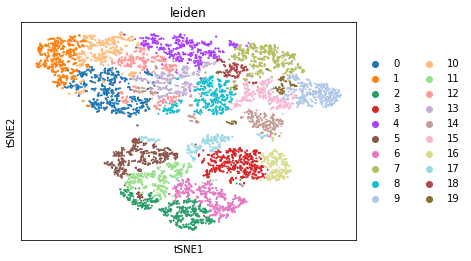

In [25]:
sc.pl.tsne(adata,save=export_name,color=["leiden"])

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


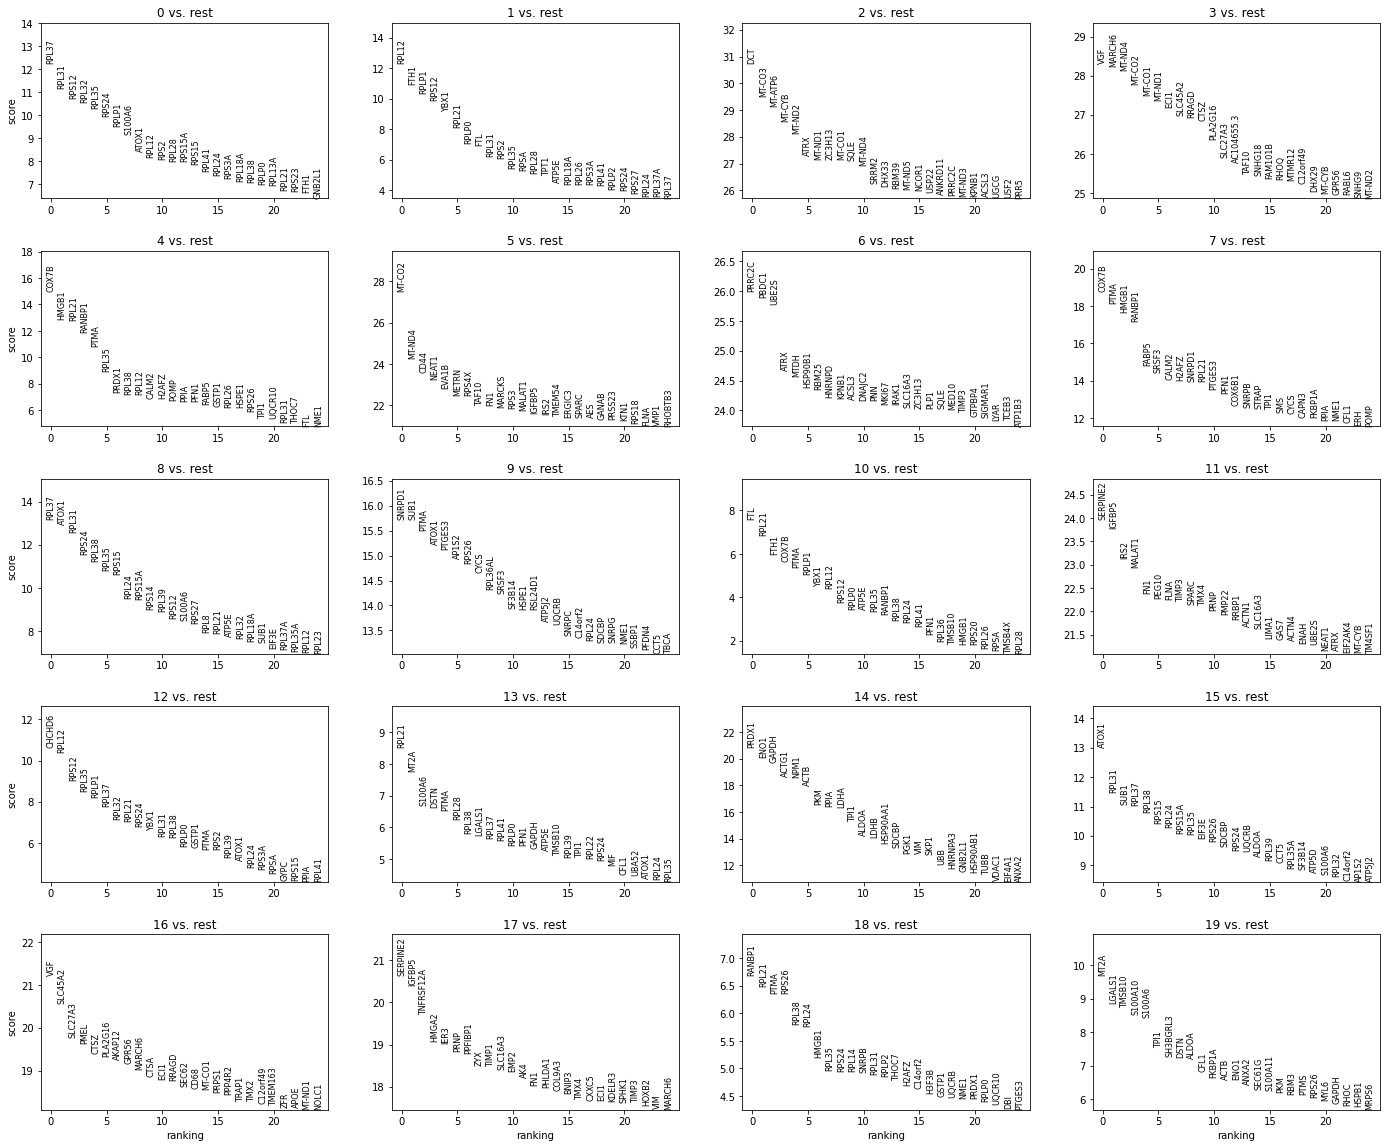

In [26]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=export_name)

In [27]:
adata.write("saved/results"+export_name+".h5ad")

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
